# Padim Example

#### Import dependencies

In [1]:
import image_anomaly_detection as iad

import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F


# 

## Training

#### Load dataset

In [3]:
data_path = '../../data/mvtec_dataset/bottle/train/good/' 
dataset = iad.IADataset(data_path)
dataloader = DataLoader(dataset, batch_size=32, pin_memory=True)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 209


#### Init the model

In [4]:
padim = iad.Padim(backbone='resnet18')

#### Fit the model to the dataset

In [5]:
padim.fit(dataloader)

Feature extraction:   0%|          | 0/7 [00:00<?, ?it/s]/home/plejd/anaconda3/envs/vision/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Feature extraction: 100%|██████████| 7/7 [00:17<00:00,  2.57s/it]


#### Save the necessary parameters

In [6]:
distributions_path = '../distributions/'
torch.save(padim.mean, distributions_path+'bottle_mean.pt')
torch.save(padim.cov_inv, distributions_path+'bottle_cov_inv.pt')

# 

## Inference
#### Load test images

In [7]:
paths = [
    '../../data/mvtec_dataset/bottle/test/broken_small/000.png',
    '../../data/mvtec_dataset/bottle/test/contamination/000.png',
    '../../data/mvtec_dataset/bottle/test/good/000.png',
    '../../data/mvtec_dataset/bottle/test/good/001.png',
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
batch = iad.to_batch(images, iad.standard_image_transform, torch.device('cpu'))

#### Load the necessary parameters

In [8]:
distributions_path = '../distributions/'
mean = torch.load(distributions_path+'bottle_mean.pt')
cov_inv = torch.load(distributions_path+'bottle_cov_inv.pt')

#### init the model

In [9]:
padim = iad.Padim(backbone='resnet18', mean=mean, cov_inv=cov_inv, device=torch.device('cpu'))

#### Make prediction

In [10]:
image_scores, score_map = padim.predict(batch)

#### Interpret the prediction

In [12]:
THRESH = 13
patch_classifications = iad.classification(score_map, THRESH)
image_classifications = iad.classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([21.5471, 23.0032, 10.2540,  9.6295])
Image classifications: tensor([0., 0., 1., 1.])


#### Visualize the results

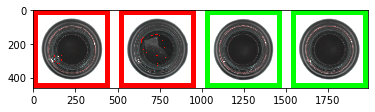

In [13]:
img = iad.boundary_image_classification_group(images, patch_classifications, image_classifications, 400)
plt.imshow(img)
plt.show()

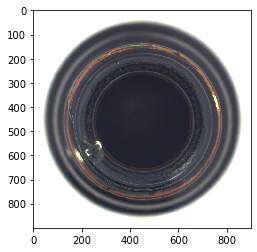

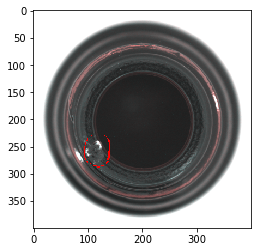

In [14]:
idx = 0
img = iad.boundary_image(images[idx], patch_classifications[idx], 400)
plt.imshow(images[idx])
plt.show()
plt.imshow(img)
plt.show()